# Problem 2 - Computing the Mandelbrot Set

### Problem 2a: Plotting the mandelbrot function using default partitioning

In [1]:
%pylab inline

import findspark
findspark.init()

from P2 import *
from pyspark import SparkContext, SparkConf
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.ticker as ticker   


# setup spark
conf = SparkConf().setAppName('Mandelbrot')
sc = SparkContext(conf=conf)

Populating the interactive namespace from numpy and matplotlib


the following functionis used later in (b)

In [2]:
%pylab inline

# creates a RDD object to pass over to the compute Mandelbrot function
def setupMandelbrot():
    
    # define here count of partitions
    num_partitions = 100;
    
    # create the space (this can be also done using spark's cartesian command)
    nx, ny = (2000, 2000)
    x = range(0, nx)
    y = range(0, ny)

    #xv, yv = np.meshgrid(x, y)

    # compute coordinate list
    #coords = zip(list(xv.ravel()), list(yv.ravel()))
    
    ## create rdd with 100 partitions
    #rdd = sc.parallelize(coords, num_partitions)
    
    rddX = sc.parallelize(x, int(np.sqrt(num_partitions)))
    rddY = sc.parallelize(y, int(np.sqrt(num_partitions)))
    rdd = rddX.cartesian(rddY) # to get tuples
    
    print rdd.getNumPartitions()
    
    return rdd

# given an rdd, this function computes the mandelbrot function
# along with a statistic about iterations per partition
def computeMandelbrot(rdd):
    # now map using mandelbrot to ((I, J), V) with (I, J) being the coordinates
    # and V the value (i.e. iteration number) of the mandelbrot set
    mb = lambda c: (c, mandelbrot((c[0] / 500.0) - 2.0, (c[1] / 500.0) - 2.0))

    # apply mandelbrot function mb to the given set
    rdd = rdd.map(mb)

    # get sum_values_for_partitions and draw a histogram of it
    iteration_stats = sum_values_for_partitions(rdd).collect()
    
    return (rdd, iteration_stats)

Populating the interactive namespace from numpy and matplotlib


100


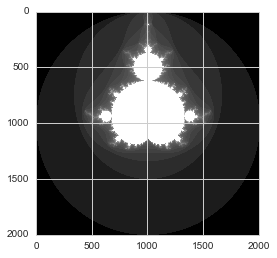

In [3]:
rdd = setupMandelbrot()

rdd, iteration_stats = computeMandelbrot(rdd)

# apply mandelbrot function and draw resulting image
im = draw_image(rdd)

In [46]:
# plot a histogram
binwidth = 0.25 * 10**5

def plotIterationStats(iteration_stats, savestr):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(np.array(iteration_stats), bins=np.arange(min(iteration_stats), max(iteration_stats) + binwidth, binwidth))
    ax.set_xlabel('total number of iterations in million')
    ax.set_ylabel('number of partitions')

    # use the trick from http://stackoverflow.com/questions/10171618/changing-plot-scale-by-a-factor-in-matplotlib
    # to scale figure in a nicer way
    scale = 10e6                                                                                                                                                                                                                                                                  
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale))                                                                                                                                                                                                           
    ax.xaxis.set_major_formatter(ticks) 

    # save figure as P2a_hist.png
    plt.savefig(savestr, dpi=120)

Plotting the number of iterations in a histogram shows, that spark used very unbalanced partitions for the actual calculation

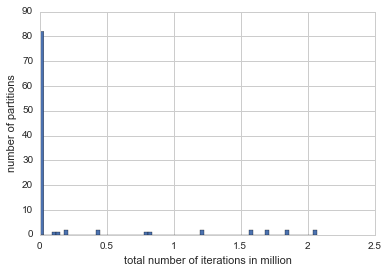

In [5]:
plotIterationStats(iteration_stats, 'P2a_hist.png')

## Problem 2b: Using a better partitioning strategy

In [6]:
num_partitions = rdd.getNumPartitions()

Looking at the picture from Problem 2a, we see that first all there seems to be symmetry. In order to load balance, we essentially want partitions that are larger around black regions and smaller around white regions. To analzye the density of white/black, we use the x-axis and sum up the white values

In [50]:
C = np.exp(im) -1

Now we compute the cumulative iterations along the x-axis and fit then a polynomial to it. This gives us then the information, how much iterations we need

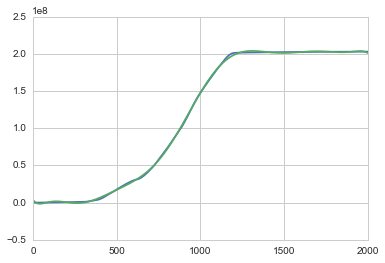

In [68]:
Cy = sum(C, axis=1)
Cy = np.cumsum(Cy)
plt.plot(Cy)
Cx = range(0, C.shape[0])
deg = 12

# maybe a logit is also a good idea to fit!
p = numpy.polyfit(Cx, Cy, deg)

p = np.poly1d(p)
xp = np.linspace(0, C.shape[0], 200)
plt.plot(xp, p(xp))

Then we divide the y-space in num-partitions lines. Their intersection with the fittes polynomial yields an x position from which we can compute the width of one partition. We use then this partitions forthe computation.

The idea is now, to first estimate the polynomial by fitting it to a at lower resolution computed curve. Then we use this approximation at a higher level

## Random partitioning

One of the easiest ways to speedup computation is by using a random partitioning.

In [36]:
# define a custom partitioner function
def randomPartition(key): 

    # return a partition id 0, ..., num_partitions-1 random
    return np.random.randint(num_partitions)


In [37]:
# # define a custom partitioner function
# def randomPartition(key): 
#     # in our case key is a tuple of x/y coordinates
#     x, y = key

#     i = (x + 2) * 500
#     j = (y + 2) * 500

#     # first idea is to use x for partitioning
#     # use last modulo for security reasons
#     return np.random.randint(num_partitions)


In [38]:
%time
rdd = setupMandelbrot()

# see https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html#partitionBy
rdd = rdd.partitionBy(num_partitions, partitionFunc=randomPartition)

rdd.take(10)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
100


[(0, 115),
 (1, 174),
 (2, 72),
 (3, 72),
 (3, 134),
 (4, 121),
 (5, 148),
 (5, 154),
 (6, 86),
 (6, 90)]

In [39]:
rdd, iteration_stats = computeMandelbrot(rdd)

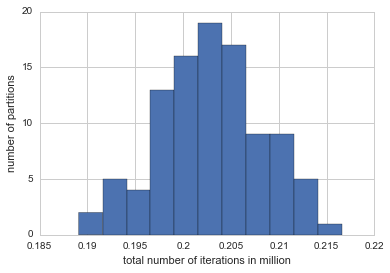

In [47]:
plotIterationStats(iteration_stats, 'P2b_hist.png')

As the plot shows, this method is really good!